
# Modeling Toolkit For Time Series Analysis

## Introduction
In this notebook, we are going to learn fundamental concepts and tools for analyzing time series data. From an astronomical perspective, this field has predominantly focused on unevenly sampled data, low signal-to-noise data, and heteroscedastic errors. The most common applications range from the detection of variability and periodicity to the treatment of nonperiodic
variability and searches for localized events.  
Despite being set in the context of time series, many tools and results are readily applicable in other domains, which we will see later in this notebook. We will extend this toolkit by introducing tools for analysis
in the frequency domain, such as Fourier analysis, discrete Fourier transform, wavelet analysis and
digital filtering.  
The main data sets used in this chapter include light curves obtained by the [LINEAR survey](https://arxiv.org/abs/1505.02082) (Lincoln Near-Earth Asteroid Research).

## Main concepts for time series analysis
The time series discussed here will be limited to two-dimensional scalar data sets: pairs of random variables, ($t_1$, $y_1$),...,($t_N$; $y_N$), with no assumptions about the sampling of the time coordinate t. In many ways, analysis methods discussed here are closely related to the parameter estimation and model selection problems discussed in the context of regression. However, unlike regression problems where different y measurements are typically treated as independent random
variables, in such models the value of $y_{i+1}$ directly depends on the preceding value $y_i$.  
  
The main tasks of time series analysis are:  
1. To characterize the presumed temporal correlation between different values of y, including its significance.  
2. To forecast (predict) future values of y.

### Import Functions and Packages

## You'll need to install AstroML: 

```pip install astroML```

http://www.astroml.org/user_guide/installation.html

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

from scipy.signal import fftconvolve

from scipy import fftpack
from matplotlib import mlab

from astroML.datasets import fetch_LIGO_large

from scipy.fftpack import fft
from scipy.stats import norm

from astroML.fourier import PSD_continuous

In [4]:
from astroML.plotting import setup_text_plots
setup_text_plots(usetex=True)

/Users/nick/anaconda3/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## 1. Fourier analysis
Fourier analysis plays a major role in the analysis of time series data. In Fourier analysis, general
functions are represented or approximated by integrals or sums of simpler trigonometric functions.   

For periodic functions, such as periodic light curves
in astronomy, it is often true that a relatively small number of terms (less than 10) suffices to reach
an approximation precision level similar to the measurement precision.

## Some useful concepts
The **Fourier transform** of function h(t) is defined as

$$H(f)=\int_{-\infty}^{\infty} h(t) exp(-i2\pi ft)dt$$

with **inverse transformation**

$$h(t)=\int_{-\infty}^{\infty} H(t) exp(-i2\pi ft)df$$

where t is time and f is frequency (for time in seconds, the unit for frequency is hertz, or Hz; the
units for H(f) are the product of the units for h(t) and inverse hertz.  
For a real function h(t), H(f) is in general a complex function.  
In the special case when h(t) is an even function such that h(-t) = h(t), H(f) is real and even as well. For example, the
Fourier transform of a pdf of a zero-mean Gaussian $N(0, \sigma)$ in the time domain is a Gaussian
$H(f) = exp(-2\pi^2 \sigma^2 f^2)$ in the frequency domain.  
When the time axis of an arbitrary function
h(t) is shifted by $\Delta t$, then the Fourier transform of $h(t + \Delta t)$ is

$$\int_{-\infty}^{\infty}h(t+\Delta t)exp(-i2\pi ft)dt = H(f)exp(i2\pi f\Delta t)$$

Therefore, the **Fourier transform of a Gaussian $N(\mu, \sigma)$** is

$$H_{Gauss}(f)=exp(-2\pi^2\sigma^2f^2)[cos(2\pi f\mu)+isin(2\pi f \mu)]$$

This is known as **"white noise"** since there is no frequency
dependence (also known as "thermal noise" or Johnson's noise).  
An important quantity in time series analysis is the one-sided **power spectral density (PSD)** function
(or power spectrum) defined for $0 \leq f < \infty$ as

$$PSD(f) \equiv |H(f)|^2+|H(-f)|^2$$

The PSD gives the amount of power contained in the frequency interval between f and f + df.  
The total power is the same whether computed in the frequency or the time domain:

$$P_{tot} \equiv \int_0^{\infty}PSD(f)df=\int_{-\infty}^{\infty}|h(t)|^2dt$$

This result is known as **Parseval's theorem**.

### (1) Fourier Reconstruction of RR-Lyrae Templates
Below is an example of a truncated Fourier representation of an RR Lyrae light curve. As we can see, the more terms that are included in the sum, the better is the resulting approximation.

#### Import a RR Lyrae template
From astroML.datasets, we take the RR Lyrae (variable star) light curve as an example. RR Lyrae has a periodical pulsation.

In [5]:
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

[=========================================]  168.7kb / 168.7kb   


#### Show Fourier reconstruction results
The thick dashed line shows the true curve; the gray lines show the approximation based on 1, 3, and 8 Fourier modes (sinusoids).

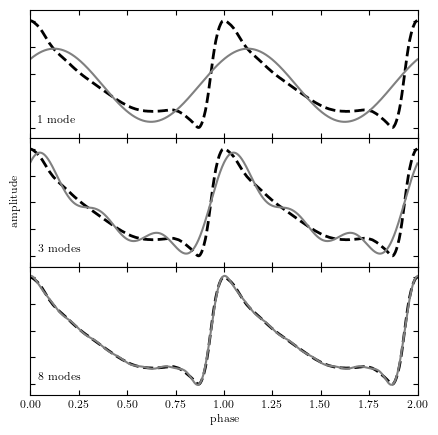

In [6]:
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

### (2) Convolution Theorem
A convolution of two functions $a(t)$ and $b(t)$ is given by

$$(a*b)(t) \equiv \int_{-\infty}^{\infty} a(t')b(t-t')dt'$$

In the above equation, the function a can
be thought of as the "convolving pattern" of the measuring apparatus, and the function $b$ is the
signal. In practice, we measure the convolved (or smoothed) version of our signal, $[a * b](t)$, and
seek to uncover the original signal $b$ using the presumably known $a$.  
The convolution theorem states that if $h = a * b$, then the Fourier transforms of $h$, $a$, and $b$ are
related by their pointwise products:

$$H(f)=A(f)B(f)$$

Thus a convolution of two functions is transformed into a simple multiplication of the associated
Fourier representations. Therefore, to obtain $b$, we can simply take the inverse Fourier transform
of the ratio $H(f)=A(f)$. In the absence of noise, this operation is exact.  
  
For further explanation, we will see a schematic representation of the convolution theorem below.

#### Generate data and define function
Generate random x, y with a given covariance length. Then we define a normalized top-hat window function.

In [7]:
# Generate data
np.random.seed(1)
x = np.linspace(0, 1, 500)
h = 0.01
C = np.exp(-0.5 * (x - x[:, None]) ** 2 / h ** 2)
y = 0.8 + 0.3 * np.random.multivariate_normal(np.zeros(len(x)), C)

# define function
w = np.zeros_like(x)
w[(x > 0.12) & (x < 0.28)] = 1

#### Show data and window function
The graph below show simulated data $D(x)$ in black line, and top-hat window function $W(x)$ in gray boxes.

(0.0, 2.0)

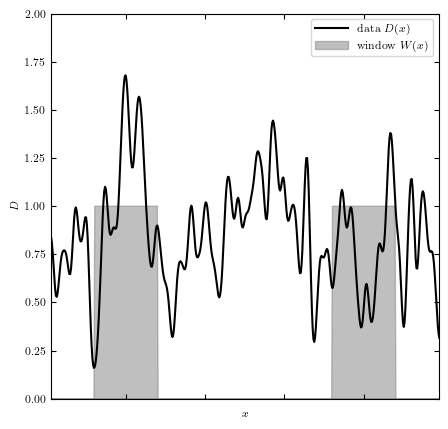

In [8]:
# Set up the plots
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

# plot the data and window function
ax1.plot(x, y, '-k', label=r'data $D(x)$')
ax1.fill(x, w, color='gray', alpha=0.5,
        label=r'window $W(x)$')
ax1.fill(x, w[::-1], color='gray', alpha=0.5)

ax1.legend()
ax1.xaxis.set_major_formatter(plt.NullFormatter())

ax1.set_xlabel('$x$')
ax1.set_ylabel('$D$')

ax1.set_xlim(0.01, 0.99)
ax1.set_ylim(0.0, 2.0)

#### Compute the Fourier transforms of the signal and window

In [9]:
y_fft = np.fft.fft(y)
w_fft = np.fft.fft(w)

yw_fft = y_fft * w_fft
yw_final = np.fft.ifft(yw_fft)

#### Show Fourier Transform result of two functions
The function on the top shows the Fourier transform of $D(x)$ and the bottom shows the transform of $W(x)$.

Text(0.5, 0, '$x$')

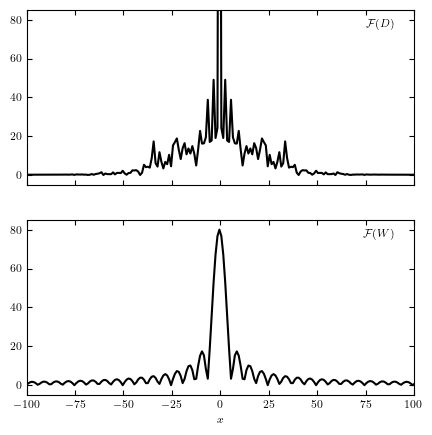

In [10]:
# Set up the plots
fig = plt.figure(figsize=(5, 5))

# plot the Fourier transforms
N = len(x)
k = - 0.5 * N + np.arange(N) * 1. / N / (x[1] - x[0])

ax = fig.add_subplot(211)
ax.plot(k, abs(np.fft.fftshift(y_fft)), '-k')

ax.text(0.95, 0.95, r'$\mathcal{F}(D)$',
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())

ax = fig.add_subplot(212)
ax.plot(k, abs(np.fft.fftshift(w_fft)), '-k')

ax.text(0.95, 0.95,  r'$\mathcal{F}(W)$', ha='right', va='top',
        transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.set_xlabel('$x$')

#### Calculate the product of Fourier transforms
We multiply the above two Fourier transform functions and get the product of them (shown below). The inverse transformation of this product give us the convolution of $[D*W](x)$.

Text(0.5, 0, '$k$')

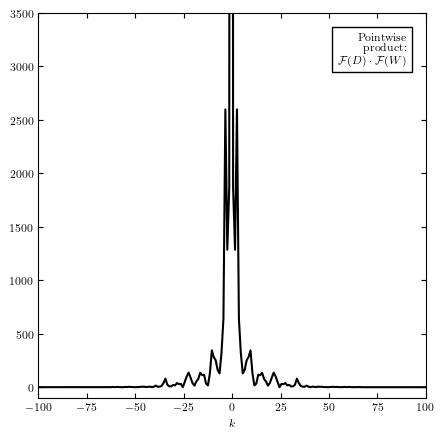

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(k, abs(np.fft.fftshift(yw_fft)), '-k')

ax.text(0.95, 0.95, ('Pointwise\nproduct:\n' +
                     r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$'),
        ha='right', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 3500)

ax.set_xlabel('$k$')

#### Perform the convolution
Use equation $(a*b)(t) \equiv \int_{-\infty}^{\infty} a(t')b(t-t')dt'$ we take the convolution of D(x) and W(x).

In [13]:
y_norm = np.convolve(np.ones_like(y), w, mode='full')
valid_indices = (y_norm != 0)
y_norm = y_norm[valid_indices]

y_w = np.convolve(y, w, mode='full')[valid_indices] / y_norm

# trick: convolve with x-coordinate to find the center of the window at
#        each point.
x_w = np.convolve(x, w, mode='full')[valid_indices] / y_norm

#### Show convolution result
The result of $[D*W](x)$ can be viewed as the data signal smoothed with the window (top-hat) function.

(0.0, 1.99)

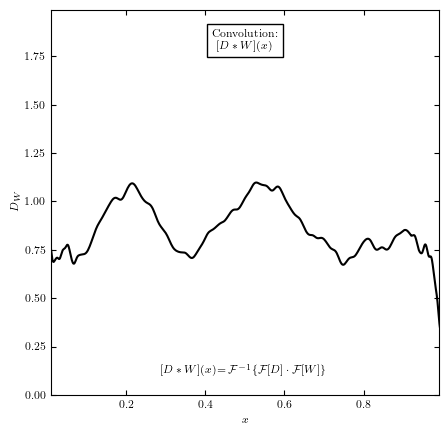

In [14]:
# plot the convolution
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(x_w, y_w, '-k')

ax.text(0.5, 0.95, "Convolution:\n" + r"$[D \ast W](x)$",
        ha='center', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.text(0.5, 0.05,
        (r'$[D \ast W](x)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='center', va='bottom', transform=ax.transAxes)

ax.set_xlabel('$x$')
ax.set_ylabel('$D_W$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 1.99)

#### Show Convolution Diagram
Here we take all the process together and express them in a clockwise order. 
* Top-left are the original data signal $D(x)$ (solid line) and top-hat window functions $W(x)$ (gray box). 
* Moving on to the top-right panel, we have the Fourier transform of two functions, with $F(D)$ as the Fourier of $D(x)$ at the top, and $F(W)$ as the Fourier of $W(x)$ at the bottom. 
* Next we multiply $F(D)$ and $F(W)$ to get a pointwise function in the bottom-right panel. 
* At last, we can take the inverse Fourier of $F(D) \cdot F(W)$ and get the convolution of function $D(x)$ and $W(x)$, as shown in the bottom-left panel.

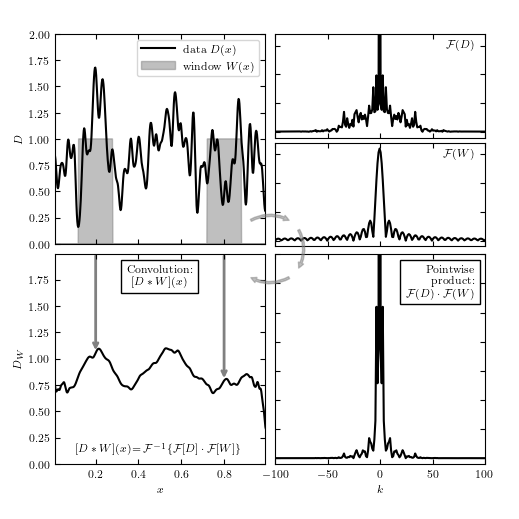

In [15]:
# Set up the plots
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.09, bottom=0.09, right=0.95, top=0.95,
                    hspace=0.05, wspace=0.05)

#----------------------------------------
# plot the data and window function
ax = fig.add_subplot(221)
ax.plot(x, y, '-k', label=r'data $D(x)$')
ax.fill(x, w, color='gray', alpha=0.5,
        label=r'window $W(x)$')
ax.fill(x, w[::-1], color='gray', alpha=0.5)

ax.legend()
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('$D$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 2.0)

#----------------------------------------
# plot the convolution
ax = fig.add_subplot(223)
ax.plot(x_w, y_w, '-k')

ax.text(0.5, 0.95, "Convolution:\n" + r"$[D \ast W](x)$",
        ha='center', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.text(0.5, 0.05,
        (r'$[D \ast W](x)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='center', va='bottom', transform=ax.transAxes)

for x_loc in (0.2, 0.8):
    y_loc = y_w[x_w <= x_loc][-1]
    ax.annotate('', (x_loc, y_loc), (x_loc, 2.0), zorder=1,
                arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax.set_xlabel('$x$')
ax.set_ylabel('$D_W$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 1.99)

#----------------------------------------
# plot the Fourier transforms
N = len(x)
k = - 0.5 * N + np.arange(N) * 1. / N / (x[1] - x[0])

ax = fig.add_subplot(422)
ax.plot(k, abs(np.fft.fftshift(y_fft)), '-k')

ax.text(0.95, 0.95, r'$\mathcal{F}(D)$',
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax = fig.add_subplot(424)
ax.plot(k, abs(np.fft.fftshift(w_fft)), '-k')

ax.text(0.95, 0.95,  r'$\mathcal{F}(W)$', ha='right', va='top',
        transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

#----------------------------------------
# plot the product of Fourier transforms
ax = fig.add_subplot(224)
ax.plot(k, abs(np.fft.fftshift(yw_fft)), '-k')

ax.text(0.95, 0.95, ('Pointwise\nproduct:\n' +
                     r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$'),
        ha='right', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 3500)

ax.set_xlabel('$k$')

ax.yaxis.set_major_formatter(plt.NullFormatter())

#------------------------------------------------------------
# Plot flow arrows
ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)

arrowprops = dict(arrowstyle="simple",
                  color="gray", alpha=0.5,
                  shrinkA=5, shrinkB=5,
                  patchA=None,
                  patchB=None,
                  connectionstyle="arc3,rad=-0.35")

ax.annotate('', [0.57, 0.57], [0.47, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.57, 0.47], [0.57, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.47, 0.47], [0.57, 0.47],
            arrowprops=arrowprops,
            transform=ax.transAxes)

plt.show()

## 2. Discrete Fourier Transform
In practice, data are always discretely sampled. When the spacing of the time interval is constant,
the discrete Fourier transform is a powerful tool.
Although in astronomy, temporal data are rarely sampled with uniform spacing (LIGO data, however, as a counterexample, will be discussed in the later notebook), uniformly sampled data is a good place to start because we have fast algorithm for this situation.  
When computing the Fourier transform for discretely and uniformly sampled data, the Fourier
integrals from 

$$H(f)=\int_{-\infty}^{\infty} h(t) exp(-i2\pi ft)dt$$
$$h(t)=\int_{-\infty}^{\infty} H(t) exp(-i2\pi ft)df$$

are translated to sums. Here we have t for time and f for frequency.
  
The discrete Fourier transform of the vector of values hj is a complex vector of length N defined
by

$$H_k=\sum_{j=0}^{N-1}h_j exp[-i2\pi jk/N]$$

where k=0,...,(N-1).  
The corresponding inverse discrete Fourier transform is defined by

$$h_j=\sum_{j=0}^{N-1}H_k exp[-i2\pi jk/N]$$

where j=0,...,(N-1). Unlike the continuous transforms, here the units for $H_k$ are the same as
the units for $h_j$ . Given $H_k$, we can represent the function described by $h_j$ as a sum of sinusoids,
as was done in the first figure.

### (1) The Nyquist sampling theorem
Let us define $h(t)$ to be band limited if $H(f) = 0$ for $|f| > f_c$, where $f_c$ is the band limit, or the
Nyquist critical frequency. If $h(t)$ is band limited, then there is some "resolution" limit in $t$ space,
$t_c = 1/(2f_c)$ below which h(t) appears "smooth." When $h(t)$ is band limited, then according to the Nyquist sampling theorem we can exactly reconstruct h(t) from evenly sampled data when $\Delta t < t_c$,
as

$$h(t)=\frac{\Delta t}{t_c} \sum_{k=-\infty}^{k=\infty} h_k \frac{sin[2\pi f_c (t-k\Delta t)]}{2\pi f_c (t-k\Delta t)}$$

This result is known as the Whittaker-Shannon, or often just Shannon, interpolation formula
(or "sinc-shifting" formula).  
Note that the summation goes to infinity, but also that the term
multiplying $h_k$ vanishes for large values of $|t - k\Delta t|$.  
For example $h(t) = sin(2 \pi t/P )$ has a period
P and is band limited with $f_c = 1/P$. If it is sampled with $\Delta t$ not larger than $P/2$, it can be fully
reconstructed at any $t$ (it is important to note that this entire discussion assumes that there is no
noise associated with sampled values $h_j$ ). On the other hand, when the sampled function h(t) is not
band limited, or when the sampling rate is not sufficient (i.e., $\Delta t > t_c$), an effect called **"aliasing"**
prevents us from exactly reconstructing h(t). In such a case, all of the power
spectral density from frequencies $|f| > f_c$ is aliased (falsely transferred) into the $-f_c < f < f_c$
range. The aliasing can be thought of as inability to resolve details in a time series at a finer detail
than that set by $f_c$. The figure below will show us the effect of aliasing.

#### Define functions and terms
Here we defind a Gaussian shaped data and its Fourier transform as an example.

In [16]:
def gaussian(x, a=1.0):
    return np.exp(-0.5 * (x / a) ** 2)


def gaussian_FT(f, a=1.0):
    return np.sqrt(2 * np.pi * a ** 2) * np.exp(-2 * (np.pi * a * f) ** 2)

a = 1.0
t = np.linspace(-5, 5, 1000)
h = gaussian(t, a)

f = np.linspace(-2, 2, 1000)
H = gaussian_FT(f, a)

#### Show a comparison of well-sampled and over-sampled results
A visualization of aliasing in the Fourier transform. 
We have two sets of four panels, and in each set:
* the top-left panel shows a signal and a regular sampling function
* the top-right panel shows the Fourier transform of the signal and sampling function
* the bottom-left panel shows the sampled data
* the bottom-right panel shows the convolution of the Fourier-space representations
  
In the top four panels, the data is well sampled, and there is little to no aliasing.   
In the bottom panels, the data is not well sampled (the spacing between two data points is larger) which leads to aliasing, as seen in the overlap of the convolved Fourier transforms. The aliasing effect can be recognized if the Fourier transform is nonzero at $|f| = 1/(2 \Delta t)$ in this example.

In [17]:
# Two plots: one well-sampled, one over-sampled
N = 12

def plot_aliasing(dt):
    """

    Parameters
    ----------

    dt : float
       

    """
    # define time-space sampling
    t_sample = dt * (np.arange(N) - N / 2)
    h_sample = gaussian(t_sample, a)

    # Fourier transform of time-space sampling
    df = 1. / dt
    f_sample = df * (np.arange(N) - N / 2)

    # Plot the results
    fig = plt.figure(figsize=(7, 3.5))
    fig.subplots_adjust(left=0.07, right=0.95, wspace=0.16,
                        bottom=0.1, top=0.85, hspace=0.05)

    # First plot: sampled time-series
    ax = fig.add_subplot(221)
    ax.plot(t, h, '-k')

    for ts in t_sample:
        ax.annotate('', (ts, 0.5), (ts, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.text(0.03, 0.95,
            ("Signal and Sampling Window\n" +
             r"Sampling Rate $\Delta t$"),
            ha='left', va='top', transform=ax.transAxes)
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1.4)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Time Domain: Multiplication')

    # second plot: frequency space
    ax = fig.add_subplot(222)
    ax.plot(f, H, '-k')
    for fs in f_sample:
        ax.annotate('', (fs, 1.5), (fs, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.text(0.03, 0.95,
            ("FT of Signal and Sampling Window\n" +
             r"$\Delta f = 1 / \Delta t$"),
            ha='left', va='top', transform=ax.transAxes)
    ax.set_ylabel('$H(f)$')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(0, 3.8)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Frequency Domain: Convolution')

    # third plot: windowed function
    ax = fig.add_subplot(223)
    for (ts, hs) in zip(t_sample, h_sample):
        if hs < 0.1:
            continue
        ax.annotate('', (ts, hs), (ts, 0), ha='center', va='center',
                    arrowprops=dict(arrowstyle='->'))
    ax.plot(t, h, ':k')
    ax.text(0.03, 0.95, "Sampled signal: pointwise\nmultiplication",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$h(t)$')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1.4)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    # fourth plot: convolved PSD
    ax = fig.add_subplot(224)
    window = np.array([gaussian_FT(f - fs, a) for fs in f_sample])
    ax.plot(f, window.sum(0), '-k')
    if dt > 1:
        ax.plot(f, window.T, ':k')
    ax.text(0.03, 0.95, "Convolution of signal FT\nand window FT",
            ha='left', va='top', transform=ax.transAxes)
    ax.set_xlabel('$f$')
    ax.set_ylabel('$H(f)$')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(0, 3.8)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    if dt > 1:
        fig.suptitle(r"Undersampled data: $\Delta t > t_c$")
    else:
        fig.suptitle(r"Well-sampled data: $\Delta t < t_c$")



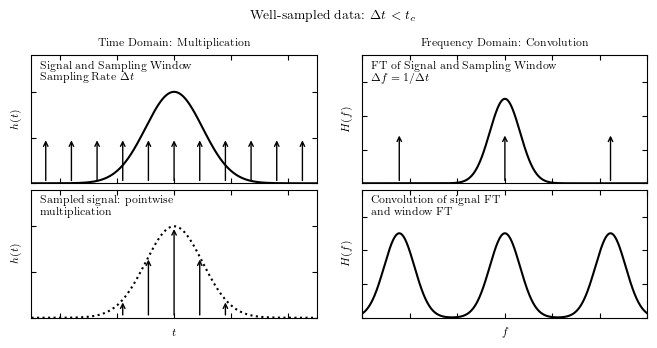

In [18]:
plot_aliasing(0.9)

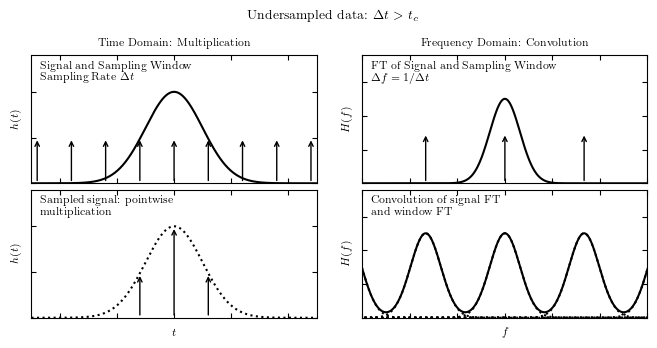

In [19]:
plot_aliasing(1.2)

### (2) The window function
The figure above shows the relationship between sampling and the window function: the sampling window
function in the time domain can be expressed as the sum of delta functions placed at sampled
observation times. The Fourier transform of a set of delta functions with spacing $\Delta t$ is another set of delta functions with spacing $1/\Delta t$; this result is at the core of the Nyquist sampling theorem. By the convolution theorem, pointwise multiplication of this sampling window with the data is equivalent to the convolution of their Fourier
representations, as seen in the right-hand panels. When data are nonuniformly sampled, the impact of sampling can be understood using the same framework.  
The sampling window is the sum of delta functions, but because the delta functions
are not regularly spaced, the Fourier transform is a more complicated, and in general complex,
function of f. The PSD can be computed using the discrete Fourier transform by constructing a
fine grid of times and setting the window function to one at the sampled times and zero otherwise.
The resulting PSD is called the **spectral window function**, and models how the Fourier-space signal
is affected by the sampling. As discussed in detail in [Fourier analysis with unequally-spaced data](http://adsabs.harvard.edu/full/1975Ap%26SS..36..137D), the observed **power spectral density (PSD)** is a convolution of
the true underlying PSD and this spectral window function.  
We will see an example of an irregular sampling window in the figure below.

#### Generate the data

In [23]:
Nbins = 2 ** 15
Nobs = 40
f = lambda t: np.sin(np.pi * t / 3)

t = np.linspace(-100, 200, Nbins)
dt = t[1] - t[0]
y = f(t)

#### Select observations and compute PSD

In [24]:
# select observations
np.random.seed(42)
t_obs = 100 * np.random.random(40)

D = abs(t_obs[:, np.newaxis] - t)
i = np.argmin(D, 1)

t_obs = t[i]
y_obs = y[i]
window = np.zeros(Nbins)
window[i] = 1

# Compute PSDs
Nfreq = int(Nbins / 2)

dt = t[1] - t[0]
df = 1. / (Nbins * dt)
f = df * np.arange(Nfreq)

PSD_window = abs(np.fft.fft(window)[:Nfreq]) ** 2
PSD_y = abs(np.fft.fft(y)[:Nfreq]) ** 2
PSD_obs = abs(np.fft.fft(y * window)[:Nfreq]) ** 2

#### Scale PSDs for plotting
Normalize the true PSD so it can be shown in the plot: in theory it's a delta function, so normalization is arbitrary.

In [25]:
PSD_window /= 500
PSD_y /= PSD_y.max()
PSD_obs /= 500

#### Show figure
An illustration of the impact of a sampling window function of resulting PSD. 
* The top-left panel shows a simulated data set with 40 points drawn from the function $y(t|P) = sin(t)$ (i.e., $f = 1/(2\pi) ~ 0.16$). 
* The bottom-left panel shows radom sampling illustracted by the vertical lines. 
* The bottom-right panel shows the PSD of sampling times, or spectral window. 
* The top-right panel shows the PSD computed for the data set from the top-left panel; it is equal to a convolution of the single peak (shaded in gray) with the window PSD shown in the bottom-right panel (e.g., the peak at f ~ 0.42 in the top-right panel can be traced to a peak at f ~ 0.26 in the bottom-right panel).

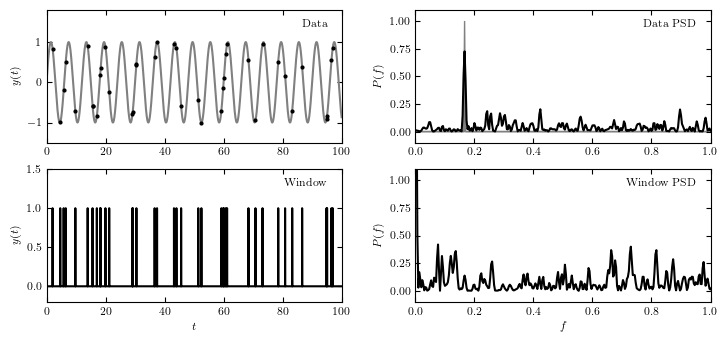

In [26]:
# Prepare the figures
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.15, hspace=0.2, wspace=0.25,
                    left=0.12, right=0.95)

# First panel: data vs time
ax = fig.add_subplot(221)
ax.plot(t, y, '-', c='gray')
ax.plot(t_obs, y_obs, '.k', ms=4)
ax.text(0.95, 0.93, "Data", ha='right', va='top', transform=ax.transAxes)
ax.set_ylabel('$y(t)$')
ax.set_xlim(0, 100)
ax.set_ylim(-1.5, 1.8)

# Second panel: PSD of data
ax = fig.add_subplot(222)
ax.fill(f, PSD_y, fc='gray', ec='gray')
ax.plot(f, PSD_obs, '-', c='black')
ax.text(0.95, 0.93, "Data PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_ylabel('$P(f)$')
ax.set_xlim(0, 1.0)
ax.set_ylim(-0.1, 1.1)

# Third panel: window vs time
ax = fig.add_subplot(223)
ax.plot(t, window, '-', c='black')
ax.text(0.95, 0.93, "Window", ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
ax.set_xlim(0, 100)
ax.set_ylim(-0.2, 1.5)

# Fourth panel: PSD of window
ax = fig.add_subplot(224)
ax.plot(f, PSD_window, '-', c='black')
ax.text(0.95, 0.93, "Window PSD", ha='right', va='top', transform=ax.transAxes)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f)$')
ax.set_xlim(0, 1.0)
ax.set_ylim(-0.1, 1.1)

plt.show()

### (3) The Fast Fourier Transform (FFT)
The **Fast Fourier transform (FFT)** is an algorithm for computing discrete Fourier transforms in
O(N logN) time, rather than O(N2) using a naive implementation. The algorithmic details for
the FFT can be found in NumRec. The speed of FFT makes it a widespread tool in the analysis
of evenly sampled, high signal-to-noise ratio, time series data.  
An example below shows such analysis for a function with a single dominant frequency: a sine wave whose amplitude is modulated by a Gaussian.

#### Generate the data

In [27]:
np.random.seed(1)

tj = np.linspace(-25, 25, 512)
hj = np.sin(tj)
hj *= norm(0, 10).pdf(tj)

#### Show result with data and calculated PSD
The discrete Fourier transform (bottom panel) for two noisy data sets shown in the top panel. For 512 evenly sampled times t (dt = 0.977), points are drawn from h(t) = a + sin(t)G(t), where G(t) is a Gaussian N(mu = 0,sigma = 10). Gaussian noise with sigma = 0.05 (top data set) and 0.005 (bottom data set) is added to signal h(t). The value of the offset a is 0.15 and 0, respectively. The discrete Fourier transform is computed as described in this section. For both noise realizations, the correct frequency f = (2pi)-1 ~ 0.159 is easily discernible in the bottom panel. Note that the height of peaks is the same for both noise realizations. The large value of abs(H(f = 0)) for data with larger noise is due to the vertical offset.

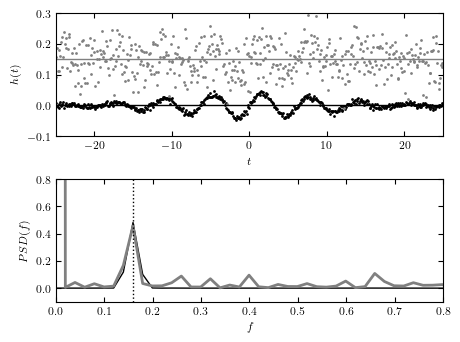

In [28]:
# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.35)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

offsets = (0, 0.15)
colors = ('black', 'gray')
linewidths = (1, 2)
errors = (0.005, 0.05)

for (offset, color, error, linewidth) in zip(offsets, colors,
                                             errors, linewidths):
    # compute the PSD
    err = np.random.normal(0, error, size=hj.shape)
    hj_N = hj + err + offset
    fk, PSD = PSD_continuous(tj, hj_N)

    # plot the data and PSD
    ax1.scatter(tj, hj_N, s=4, c=color, lw=0)
    ax1.plot(tj, 0 * tj + offset, '-', c=color, lw=1)
    ax2.plot(fk, PSD, '-', c=color, lw=linewidth)

# vertical line marking the expected peak location
ax2.plot([0.5 / np.pi, 0.5 / np.pi], [-0.1, 1], ':k', lw=1)

ax1.set_xlim(-25, 25)
ax1.set_ylim(-0.1, 0.3001)

ax1.set_xlabel('$t$')
ax1.set_ylabel('$h(t)$')

ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax2.set_xlim(0, 0.8)
ax2.set_ylim(-0.101, 0.801)

ax2.set_xlabel('$f$')
ax2.set_ylabel('$PSD(f)$')

plt.show()